In [1]:
!pip install matplotlib deap

In [2]:
# Required Libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Task 1 - Define the number of locations and vehicles
num_locations = 20  # Define how many locations (excluding the depot) the vehicles need to visit
locations = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(num_locations)]  # Generate random (x, y) coordinates for each location
depot = (0, 0)  # Define the central depot location as a fixed point
num_vehicles = 3  # Define how many vehicles are available to visit the locations

# Genetic Algorithm Setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))  # Define fitness function to minimize. The two objectives are total distance and balance penalty.
creator.create("Individual", list, fitness=creator.FitnessMin)  # Define individual structure. Individuals are lists with a fitness attribute.

# Task 2 - Finish setting up the individuals and population
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(num_locations), num_locations)  # Function to generate a list of unique, randomly ordered location indices
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)  # Function to create an individual as a shuffled list of location indices
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Function to create a population of individuals

# Fitness Function
def evalVRP(individual):
    total_distance = 0
    distances = []  # Track distance traveled by each vehicle for balance calculation
    # Split the list of locations among vehicles, ensuring each starts and ends at the depot
    for i in range(num_vehicles):
        vehicle_route = [depot] + [locations[individual[j]] for j in range(i, len(individual), num_vehicles)] + [depot]
        # Calculate total distance traveled by this vehicle
        vehicle_distance = sum(np.linalg.norm(np.array(vehicle_route[k+1]) - np.array(vehicle_route[k])) for k in range(len(vehicle_route)-1))
        total_distance += vehicle_distance
        distances.append(vehicle_distance)
    balance_penalty = np.std(distances)  # Use standard deviation of distances as a penalty for imbalance among vehicles
    return total_distance, balance_penalty

toolbox.register("evaluate", evalVRP)  # Register the evaluation function
toolbox.register("mate", tools.cxPartialyMatched)  # Register the crossover function suitable for permutation-based representation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Register the mutation function to shuffle indices with a 5% chance per index
toolbox.register("select", tools.selTournament, tournsize=3)  # Register the selection function using tournament selection

# Plotting Function
def plot_routes(individual, title="Routes"):
    plt.figure()
    # Plot locations as blue dots and the depot as a red square
    for (x, y) in locations:
        plt.plot(x, y, 'bo')
    plt.plot(depot[0], depot[1], 'rs')

    # Draw routes for each vehicle
    for i in range(num_vehicles):
        vehicle_route = [depot] + [locations[individual[j]] for j in range(i, len(individual), num_vehicles)] + [depot]
        plt.plot(*zip(*vehicle_route), '-')

    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

# Running the Genetic Algorithm
def main():
    random.seed(42)  # Seed for reproducibility
    pop = toolbox.population(n=300)  # Generate initial population
    hof = tools.HallOfFame(1)  # Hall of Fame to store the best individual

    # Setup statistics to track
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    # Run the genetic algorithm
    algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 300, stats=stats, halloffame=hof)

    # Plot the best route found
    plot_routes(hof[0], "Optimal Route")
    return pop, stats, hof

In [3]:
# Nearest Neighbor Method
def calculate_distance_matrix(locations):
    num_points = len(locations)
    dist_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            dist_matrix[i, j] = np.linalg.norm(np.array(locations[i]) - np.array(locations[j]))
    return dist_matrix

def nearest_neighbor(dist_matrix, num_vehicles):
    num_points = dist_matrix.shape[0]
    visited = np.zeros(num_points, dtype=bool)
    routes = []
    total_distance = 0

    while np.sum(visited) < num_points:
        current_node = 0
        route = [current_node]
        visited[current_node] = True

        while True:
            current = route[-1]
            nearest = None
            min_dist = float('inf')

            for neighbor in np.where(~visited)[0]:
                if dist_matrix[current, neighbor] < min_dist:
                    nearest = neighbor
                    min_dist = dist_matrix[current, neighbor]

            if nearest is None or len(route) > num_points // num_vehicles:
                break

            route.append(nearest)
            visited[nearest] = True
            total_distance += min_dist

        total_distance += dist_matrix[route[-1], 0]
        route.append(0)
        routes.append(route)

    return total_distance, routes

Nearest Neighbor Total Distance: 679.9625625344828
Nearest Neighbor Routes:
Vehicle 1: [0, 10, 17, 14, 4, 8, 1, 16, 0]
Vehicle 2: [0, 15, 9, 6, 7, 11, 3, 13, 0]
Vehicle 3: [0, 20, 5, 12, 18, 19, 2, 0]
gen	nevals	avg    	min    
0  	300   	673.928	2.79769
1  	213   	643.31 	2.79769
2  	243   	627.011	6.63743
3  	232   	614.469	1.43372
4  	233   	610.594	1.43372
5  	218   	594.171	1.43372
6  	213   	583.444	1.43372
7  	233   	587.506	1.0114 
8  	219   	569.668	1.0114 
9  	209   	552.161	1.43372
10 	224   	544.04 	1.43372
11 	230   	540.63 	1.43372
12 	230   	535.962	1.43372
13 	217   	517.365	0.765433
14 	231   	508.585	0.765433
15 	250   	504.523	0.765433
16 	238   	499.514	0.765433
17 	236   	483.867	1.14882 
18 	225   	477.383	1.43372 
19 	225   	471.011	1.43372 
20 	209   	462.155	1.43372 
21 	232   	460.679	2.06715 
22 	237   	459.385	1.8719  
23 	217   	455.017	4.25443 
24 	227   	443.798	1.91974 
25 	246   	441.504	1.20195 
26 	233   	429.956	1.20195 
27 	219   	427.453	1.20195 
2

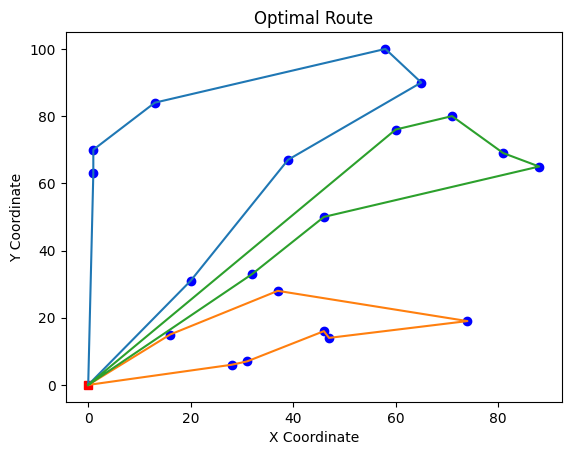

Genetic Algorithm Total Distance: 668.4702396752098
Genetic Algorithm Balance Penalty: 42.360814686315805
Improvement in Total Distance: 1.69%


In [4]:
# Run Nearest Neighbor
dist_matrix = calculate_distance_matrix([depot] + locations)
nn_total_distance, nn_routes = nearest_neighbor(dist_matrix, num_vehicles)

print(f"Nearest Neighbor Total Distance: {nn_total_distance}")
print("Nearest Neighbor Routes:")
for i, route in enumerate(nn_routes):
    print(f"Vehicle {i+1}: {route}")

# Run Genetic Algorithm
pop, stats, hof = main()
ga_total_distance, ga_balance_penalty = hof[0].fitness.values

print(f"Genetic Algorithm Total Distance: {ga_total_distance}")
print(f"Genetic Algorithm Balance Penalty: {ga_balance_penalty}")

# Comparison
improvement_distance = (nn_total_distance - ga_total_distance) / nn_total_distance * 100
print(f"Improvement in Total Distance: {improvement_distance:.2f}%")